## Predicting Stock Price with LSTM

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import time
from tqdm._tqdm_notebook import tqdm_notebook
data = pd.read_csv("ge.us.txt",header=None)
data =data.iloc[1:,:]
data

c:\users\rania\desktop\nlpproject_env\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  


,0,1,2,3,4,5,6
1,1962-01-02,0.6277,0.6362,0.6201,0.6201,2575579,0
2,1962-01-03,0.6201,0.6201,0.6122,0.6201,1764749,0
3,1962-01-04,0.6201,0.6201,0.6037,0.6122,2194010,0
4,1962-01-05,0.6122,0.6122,0.5798,0.5957,3255244,0
5,1962-01-08,0.5957,0.5957,0.5716,0.5957,3696430,0
...,...,...,...,...,...,...,...
14054,2017-11-06,20.52,20.53,20.08,20.13,60641787,0
14055,2017-11-07,20.17,20.25,20.12,20.21,41622851,0
14056,2017-11-08,20.21,20.32,20.07,20.12,39672190,0
14057,2017-11-09,20.04,20.071,19.85,19.99,50831779,0


#### Reading and Analysing the data:

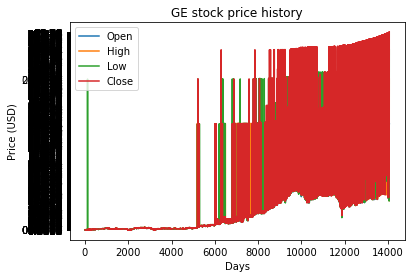

In [2]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(data.iloc[:,1])
plt.plot(data.iloc[:,2])
plt.plot(data.iloc[:,3])
plt.plot(data.iloc[:,4])
plt.title('GE stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'],loc='upper left')
plt.show()

#### Price -[Open,Close,High,Low] dont vary so much !

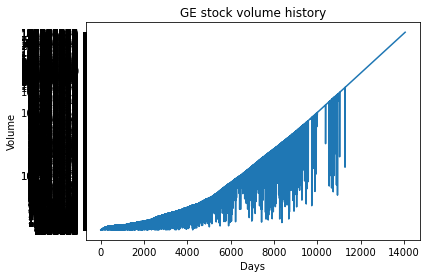

In [3]:
plt.figure()
plt.plot(data.iloc[:,5])
plt.title('GE stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()

#### Looks like when the prices are low the volumes go up!


In [4]:
#preprocessing!
data = data.rename({0:"Date",1:"Open",2:"High",3:"Low",4:"Close",5:"Volume",6:"OpenInt"},axis = 1)
data


,Date,Open,High,Low,Close,Volume,OpenInt
1,1962-01-02,0.6277,0.6362,0.6201,0.6201,2575579,0
2,1962-01-03,0.6201,0.6201,0.6122,0.6201,1764749,0
3,1962-01-04,0.6201,0.6201,0.6037,0.6122,2194010,0
4,1962-01-05,0.6122,0.6122,0.5798,0.5957,3255244,0
5,1962-01-08,0.5957,0.5957,0.5716,0.5957,3696430,0
...,...,...,...,...,...,...,...
14054,2017-11-06,20.52,20.53,20.08,20.13,60641787,0
14055,2017-11-07,20.17,20.25,20.12,20.21,41622851,0
14056,2017-11-08,20.21,20.32,20.07,20.12,39672190,0
14057,2017-11-09,20.04,20.071,19.85,19.99,50831779,0


#### Normalising the given data since Volume attribute has varying values when comapred to the other attributes! Also helps to find local/Global Minimum Efficiently

In [5]:

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

train_cols = ["Open","High","Low","Close","Volume"]
df_train, df_test = train_test_split(data, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))
# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

Train and Test size 11246 2812


### Converting n-array to time series format: 

#### y_col_index: is the index of the column of the output.


#### TIME_STEPS:  number of rows as input(60)  and sets the TIME_STEPS+1th data as corresponding output and so on.

In [41]:
TIME_STEPS = 60
BATCH_SIZE = 20
def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y
#To Remove the Odd Samples:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat
x_t, y_t = build_timeseries(x_train, 3)


length of time-series i/o (11186, 60, 5) (11186,)


#### Getting our Training,Test and Validation Datasets ready for LSTM!

In [27]:
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)
x_train.shape


length of time-series i/o (11186, 60, 5) (11186,)



length of time-series i/o (2752, 60, 5) (2752,)


(11246, 5)

#### Building the model LSTM!

In [8]:
import keras
from keras.models import Sequential
from keras.layers import Dense,LSTM,Embedding,Dropout
from keras import optimizers
from keras.callbacks import CSVLogger
lr: 0.00010000

lstm_model = Sequential()
lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(1,activation='sigmoid'))
lstm_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()


Using TensorFlow backend.
c:\users\rania\desktop\nlpproject_env\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\rania\desktop\nlpproject_env\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\rania\desktop\nlpproject_env\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\rania\desktop\nlpproject_env\lib

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (20, 100)                 42400     
_________________________________________________________________
dropout_1 (Dropout)          (20, 100)                 0         
_________________________________________________________________
dense_1 (Dense)              (20, 20)                  2020      
_________________________________________________________________
dense_2 (Dense)              (20, 1)                   21        
Total params: 44,441
Trainable params: 44,441
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = lstm_model.fit(x_t, y_t, epochs=10, verbose=2, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                    trim_dataset(y_val, BATCH_SIZE)))

Train on 11180 samples, validate on 1360 samples
Epoch 1/10
 - 18s - loss: 0.0119 - accuracy: 2.6834e-04 - val_loss: 0.0487 - val_accuracy: 0.0000e+00
Epoch 2/10
 - 21s - loss: 0.0061 - accuracy: 2.6834e-04 - val_loss: 0.0247 - val_accuracy: 0.0000e+00
Epoch 3/10
 - 21s - loss: 0.0044 - accuracy: 2.6834e-04 - val_loss: 0.0432 - val_accuracy: 0.0000e+00
Epoch 4/10
 - 33s - loss: 0.0028 - accuracy: 2.6834e-04 - val_loss: 0.0278 - val_accuracy: 0.0000e+00
Epoch 5/10
 - 35s - loss: 0.0024 - accuracy: 2.6834e-04 - val_loss: 0.0409 - val_accuracy: 0.0000e+00
Epoch 6/10
 - 35s - loss: 0.0026 - accuracy: 2.6834e-04 - val_loss: 0.0388 - val_accuracy: 0.0000e+00
Epoch 7/10
 - 36s - loss: 0.0026 - accuracy: 2.6834e-04 - val_loss: 0.0206 - val_accuracy: 0.0000e+00
Epoch 8/10
 - 35s - loss: 0.0021 - accuracy: 2.6834e-04 - val_loss: 0.0328 - val_accuracy: 0.0000e+00
Epoch 9/10
 - 36s - loss: 0.0025 - accuracy: 2.6834e-04 - val_loss: 0.0464 - val_accuracy: 0.0000e+00
Epoch 10/10
 - 36s - loss: 0.0050

In [21]:
from sklearn.metrics import mean_squared_error
y_pred = lstm_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

Error is 0.007686057565817218 (1360,) (1360,)
[0.42719817 0.4028773  0.41531485 0.3998031  0.4035693  0.41745666
 0.40026355 0.3851096  0.3869146  0.39096874 0.39876074 0.4097994
 0.41632727 0.39320374 0.4295314 ]
[0.32378063 0.32499919 0.32800358 0.32905407 0.32905407 0.33031465
 0.32943225 0.33205846 0.32659593 0.32747834 0.31770881 0.31092267
 0.31258244 0.32378063 0.32592362]


#### Converting the predicted value to range of real data:

In [22]:
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

[20.792364 19.634764 20.226753 19.488441 19.667702 20.328697 19.510357
 18.789076 18.874989 19.067953 19.438828 19.964235 20.274942 19.174332
 20.903418]
[15.87  15.928 16.071 16.121 16.121 16.181 16.139 16.264 16.004 16.046
 15.581 15.258 15.337 15.87  15.972]


#### Plottting the Predicted Data:

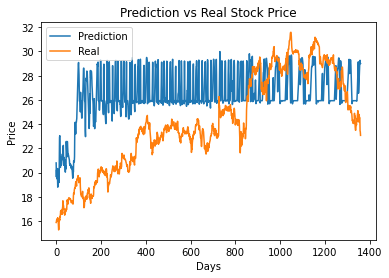

In [23]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()
#plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_BS'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))
#print_time("program completed ", stime)